## Name the bird!

<font size="4">Machine learning can prove to be of great help for the bird watcher community. This blog is to demonstrate how this can be done. <br><br>**About the dataset**: I collected ~2882 images of Indian birds of 10 different species, from various sources. Of these we use 2582 images, randomly selected for the 10 species, for the train set 300 randomly selected images (10 for each species) for the test set. Below you can see the 10 bird species used here.<br><br> <img src="../../../images/bird_example.png" style="width:450px" alt="Image not found"> <br><br> **About the model**: I used the VGG16 16-layer convolutional neural network that was used by the VGG team in the ILSVRC-2014 competition. I changed the final layer to have 10 output classes and re-trained all the weights of the model for my dataset.</font>

<font size="4"> First let's import some necessary modules.</font>

In [48]:
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import inspect
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# checking for gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

<font size="4">**Intitial Image Processing:**<br><br> The original images were quite big included many unnecessary background objects. So the birds had to be detected and cropped out from the original images before using them for the training. We used the YOLO (You Only Look Once) package version 3 for this purpose as described in my previous blog. The before and after images are shown below.</font><br>
<img src="../../../images/YOLO_example.png" alt="Image not found"><br>

<font size="4">VGG16 net requires input images to be formatted in a certain way, so all train and test images have to be further transformed in the way described below.</font>

In [35]:

compose = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

compose_test = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = ImageFolder('../../../data/train', transform=compose)
test = ImageFolder('../../../data/test', transform=compose_test)
train_loader = DataLoader(train, batch_size=20, shuffle=True)
test_loader = DataLoader(test, batch_size=20, shuffle=True)

<font size="4">Now let's take at look at some of the (transformed) images.</font>

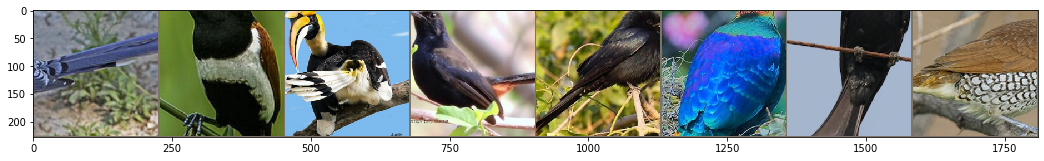

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.subplots(figsize=(18,13))
    plt.imshow(inp)
    #if title is not None:
        #plt.title(title,fontsize=20)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
display = True
if display:
    out = torchvision.utils.make_grid(inputs[:8])
    class_names = test.classes
    imshow(out, title=[class_names[x] for x in classes[:8]])

<font size="4">Let's get the VGG16 model with the pretrained weights.</font>

In [3]:
# import vgg16
n_inputs = 4096
n_classes = 10

transfer_model = models.vgg16(pretrained=True, progress=True)

'''
Since we will be using the pretrained model weights we will only remove the final output layer 
which currently has around 1000 outputs and replace with a fully connected layer with ten outputs. 
We will also freeze the weights of the rest of the layers 
'''
for params in transfer_model.parameters():
    params.requires_grad = False #makes sure that weights are not updated during the training

#Get the number of inputs for the final layer
# Add on classifier
transfer_model.classifier[6] = nn.Sequential(
                                              nn.Linear(n_inputs, 256), 
                                              nn.ReLU(), 
                                              nn.Dropout(0.4),
                                              nn.Linear(256, n_classes),                   
                                              nn.LogSoftmax(dim=1))

print(transfer_model.classifier)
transfer_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=transfer_model.parameters(), lr=.0001, momentum=0.9)

#Reduce learning rate lr by a factor of 0.1 every 7 epochs

step_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): LogSoftmax()
  )
)


<font size="4">Let's train the model for 10 epochs on the training set.</font>

In [5]:
nb_epochs = 10

sigmoid = nn.Sigmoid()
test_loss_epoch = []
test_accuracy = []
train_loss_epoch = []
train_accuracy = []
for epoch in range(nb_epochs):
    train_acc = 0
    test_acc = 0
    train_loss = []
    test_loss = []
    
    transfer_model.train()
    with torch.set_grad_enabled(True):
        for i, (images, labels) in enumerate(train_loader):
            inputs = images.to(device)
            targets = labels.to(device)

            #Zero all gradients
            optimizer.zero_grad()

            #Forward pass

#             output, _ = transfer_model(inputs)
            output = transfer_model(inputs)
            #Compute binary cross entropy loss
            loss = criterion(output, targets)
            _, pred = torch.max(output, 1)


            train_acc += torch.sum(targets == pred)

            #Backpropagate
            loss.backward()
            #Update parameters that requires grad
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
#             if i%10 == 0:
#                 print('Iteration {} in Epoch {} Train Loss: {}'.format(i, epoch, loss))
    transfer_model.eval()
    with torch.set_grad_enabled(False):
        for i, (images, labels) in enumerate(test_loader):
            inputs_test = images.to(device)
            targets_test = labels.to(device)

            output = transfer_model(inputs_test)
            # Compute cross entropy loss
            loss_test = criterion(output, targets_test)
            _, pred = torch.max(output, 1)
            test_acc += torch.sum(targets_test == pred)
            test_loss.append(loss_test.detach().cpu().numpy())
    #Change learning rate every seven epochs
    step_lr.step()


    train_loss_epoch.append(sum(train_loss)/len(train_loader))
    test_loss_epoch.append(sum(test_loss)/len(test_loader))
    train_accuracy.append(train_acc.cpu().numpy()/len(train))
    test_accuracy.append(test_acc.cpu().numpy()/len(test))
    print('Epoch: {}, Train Loss: {} Train Accuracy: {}// Test Loss: {} Test Accuracy: {}'.format(epoch, sum(train_loss)/len(train_loader), train_acc.cpu().numpy()/len(train), sum(test_loss)/len(test_loader), test_acc.cpu().numpy()/len(test)))

Epoch: 0, Train Loss: 2.2078845757704513 Train Accuracy: 0.21107668474051122// Test Loss: 1.9563590288162231 Test Accuracy: 0.6766666666666666
Epoch: 1, Train Loss: 1.8686246917797968 Train Accuracy: 0.4918667699457785// Test Loss: 1.5691173632939657 Test Accuracy: 0.81
Epoch: 2, Train Loss: 1.534234355046199 Train Accuracy: 0.6576297443841983// Test Loss: 1.2194353302319845 Test Accuracy: 0.8933333333333333
Epoch: 3, Train Loss: 1.2695348579149979 Train Accuracy: 0.7207591014717274// Test Loss: 0.9604244589805603 Test Accuracy: 0.9
Epoch: 4, Train Loss: 1.042966175537843 Train Accuracy: 0.7714949651432997// Test Loss: 0.7750810503959655 Test Accuracy: 0.9033333333333333
Epoch: 5, Train Loss: 0.901863431930542 Train Accuracy: 0.8001549186676995// Test Loss: 0.6459242512782415 Test Accuracy: 0.92
Epoch: 6, Train Loss: 0.7975481480360032 Train Accuracy: 0.8063516653756778// Test Loss: 0.5545297682285308 Test Accuracy: 0.94
Epoch: 7, Train Loss: 0.756856154020016 Train Accuracy: 0.8241673

<br>
<font size="4">Plotting the train and test accuracies and losses.</font>

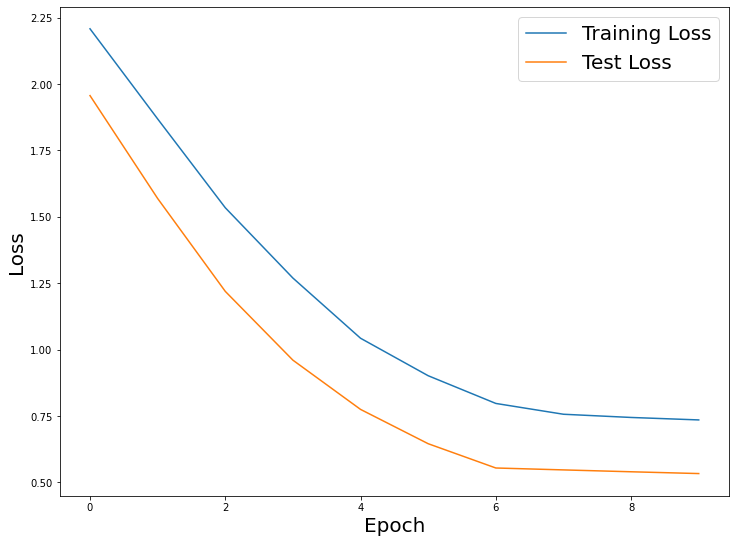

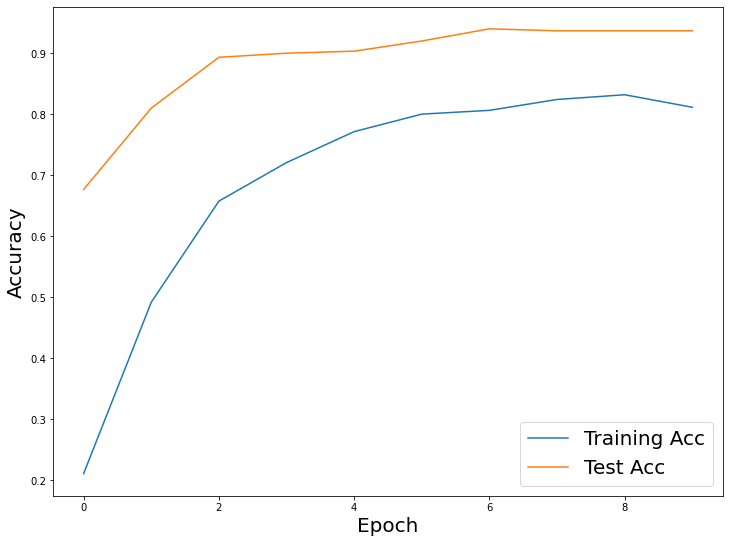

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (12, 9))
ax.plot(train_loss_epoch, label='Training Loss')
ax.plot(test_loss_epoch, label='Test Loss')
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.legend(loc='best', fontsize=20)
fig.savefig('loss_inception_net.png', dpi=300)

fig1, ax1 = plt.subplots(1, 1, figsize = (12, 9))
ax1.plot(train_accuracy, label='Training Acc')
ax1.plot(test_accuracy, label='Test Acc')
ax1.set_xlabel('Epoch', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.legend(loc='best', fontsize=20)
fig1.savefig('accuracy_inception_net.png', dpi=300)

<font size="4">Plotting the confusion matrix</font>

In [54]:
from sklearn.metrics import confusion_matrix
import itertools

In [36]:
# classes to indices dictionary
class2idx = train_loader.dataset.class_to_idx

In [37]:
# indices to classes dictionary
idx2class = {value:key for key, value in class2idx.items()}

In [52]:
# confusion matrix plotting function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # print(cm)
    
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111)
    
    cax = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(cax)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
  
    plt.yticks(tick_marks, classes)
    plt.xlim(len(classes)-0.5,-0.5)
    plt.ylim(len(classes)-0.5,-0.5)
  
    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()

## Confusion Matrix Plot for training set of bird images

In [51]:
transfer_model = torch.load('../../../models/model.pt',map_location=torch.device('cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=transfer_model.parameters(), lr=.0001, momentum=0.9)

y_pred = []
y_true = []
train_acc = 0
with torch.set_grad_enabled(False):
    for i, (images, labels) in enumerate(train_loader):
        inputs = images.to(device)
        targets = labels.to(device)

        output = transfer_model(inputs)
        _, pred = torch.max(output, 1)
        train_acc += torch.sum(targets == pred)
        labels_list = labels.numpy().tolist()
        output_list = pred.detach().cpu().numpy().tolist()
        y_pred.extend(output_list)
        y_true.extend(labels_list) 

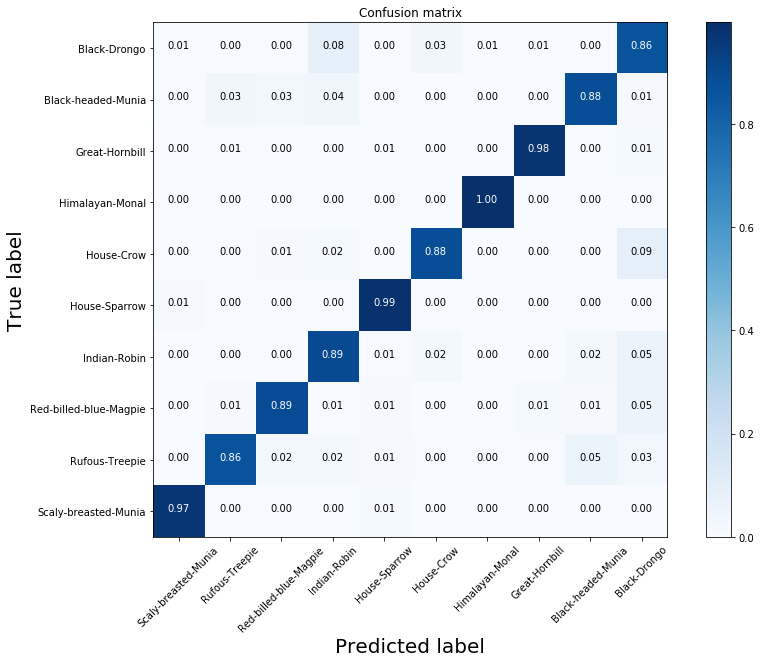

In [55]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, idx2class.values(), normalize=True)

<font size="4">We see here that the model works too well for certain bird species classes like Great-Hornbill, Himlayan-Monal and House-Sparrow and Scaly-breasted-Munia with an accuracy of >=97%. However, even for the worst detected species (Black-Drongo and Rufous-Treepie), the accuracy is really good (86%).</font><br>

## Confusion Matrix Plot for test set of bird images

In [58]:
y_pred = []
y_test = []
test_acc = 0
with torch.set_grad_enabled(False):
    for i, (images, labels) in enumerate(test_loader):
        inputs_test = images.to(device)
        targets_test = labels.to(device)

        output = transfer_model(inputs_test)
        _, pred = torch.max(output, 1)
        test_acc += torch.sum(targets_test == pred)
        labels_list = labels.numpy().tolist()
        output_list = pred.detach().cpu().numpy().tolist()
        y_pred.extend(output_list)
        y_test.extend(labels_list) 

In [59]:
cm = confusion_matrix(y_test, y_pred)

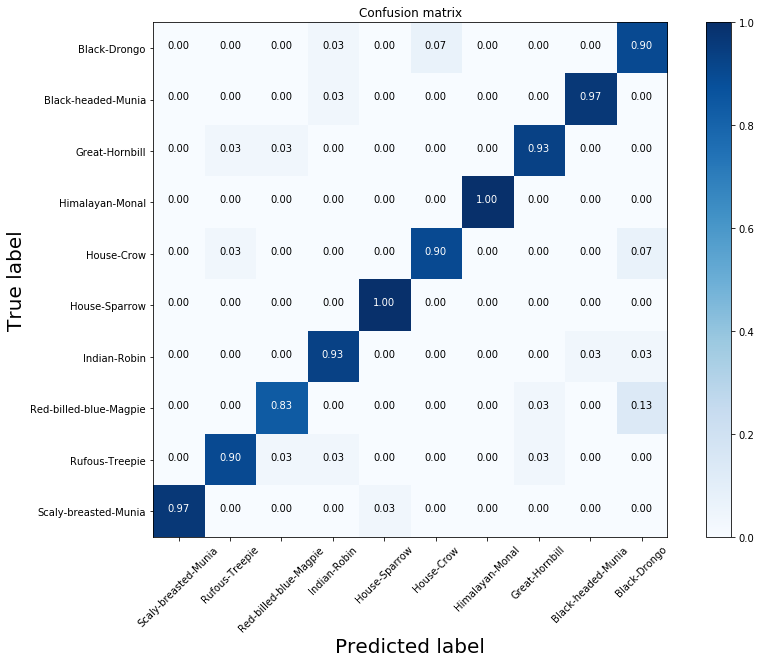

In [60]:
plot_confusion_matrix(cm, idx2class.values(), normalize=True)

<font size="4">For the test set, the prediction accuracies are the best (>=97%) for the Himalayan-Monal, House-Sparrow, Black-headed-Munia and Scaly-breasted-Munia classes, although even the worst detected class of Red-billed-blue-magpie has a prediction anaccuracy of 83%.</font>

## Checking the model on a randomly picked bird image from the test set

In [49]:
# Save model
torch.save(transfer_model, '../../../models/model.pt')

In [4]:
# defining the model afresh

model1 = torch.load('../../../models/model.pt',map_location=torch.device('cpu'))

Scaly-breasted-Munia


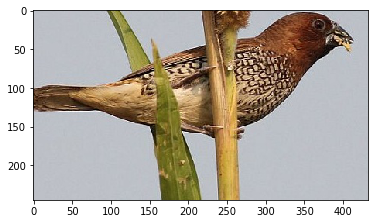

In [68]:
import random
import cv2
from PIL import Image

sp = random.choice(os.listdir("../../../data/test/"))
print(sp)
image_name = random.choice(os.listdir("../../../data/test/"+sp))
path = "../../../data/test/"+sp+"/"+image_name
image = Image.open(path)
plt.imshow(np.asarray(image))

In [69]:
compose_test = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_image = compose_test(image)
input_im = torch.unsqueeze(transform_image,0)
output = model1(input_im)
_, pred = torch.max(output, 1)
print(idx2class[pred.numpy()[0]])

Scaly-breasted-Munia


<br>
<font size="4">So the model seems to be working well for the radomly picked bird image.</font>